### Importing the necessary libraries

In [1]:
# Importing the libraries
import numpy as np
import os 
import cv2 # used only for loading the image
import matplotlib.pyplot as plt # used only for displaying the image

### Defining the required functions

In [2]:
# this function is responsible for calculating the histogram of an image
def calculate_histogram(image, num_bins=256):
    histogram = np.zeros(num_bins, dtype=np.int32) # initialize the histogram
    for pixel_value in image.ravel(): # ravel() returns a contiguous flattened array
        histogram[pixel_value] += 1 # increment the count of the pixel value
    return histogram # return the histogram

# this function is responsible for calculating the normalized histogram of an image
def calculate_normalized_histogram(image, num_bins=256):
    histogram = calculate_histogram(image, num_bins) # calculate the histogram
    sum_of_histogram = np.sum(histogram) # sum of all the pixel values
    histogram = histogram / sum_of_histogram # normalize the histogram
    return histogram # return the normalized histogram

# this function is responsible for calculating the cumulative histogram of an image
def calculate_cumulative_histogram(histogram):
    sum_of_histogram = np.sum(histogram) # sum of all the pixel values
    histogram = histogram / sum_of_histogram # normalize the histogram
    cumulative_histogram = np.zeros(histogram.shape, dtype=np.float32) # initialize the cumulative histogram
    cumulative_histogram[0] = histogram[0] 
    for i in range(1, histogram.shape[0]): # calculate the cumulative histogram
        cumulative_histogram[i] = cumulative_histogram[i - 1] + histogram[i]
    return cumulative_histogram # return the cumulative histogram

In [3]:
# opeining the images in grayscale and storing them in a list
image_folder_path = os.path.join(os.getcwd(), 'Dataset', 'histogram_matching')
image_set = []
for image_name in os.listdir(image_folder_path): # iterate over all the images in the folder
    img = cv2.imread(os.path.join(image_folder_path, image_name), cv2.IMREAD_GRAYSCALE) # read the image in grayscale
    image_set.append(img) # append the image to the list

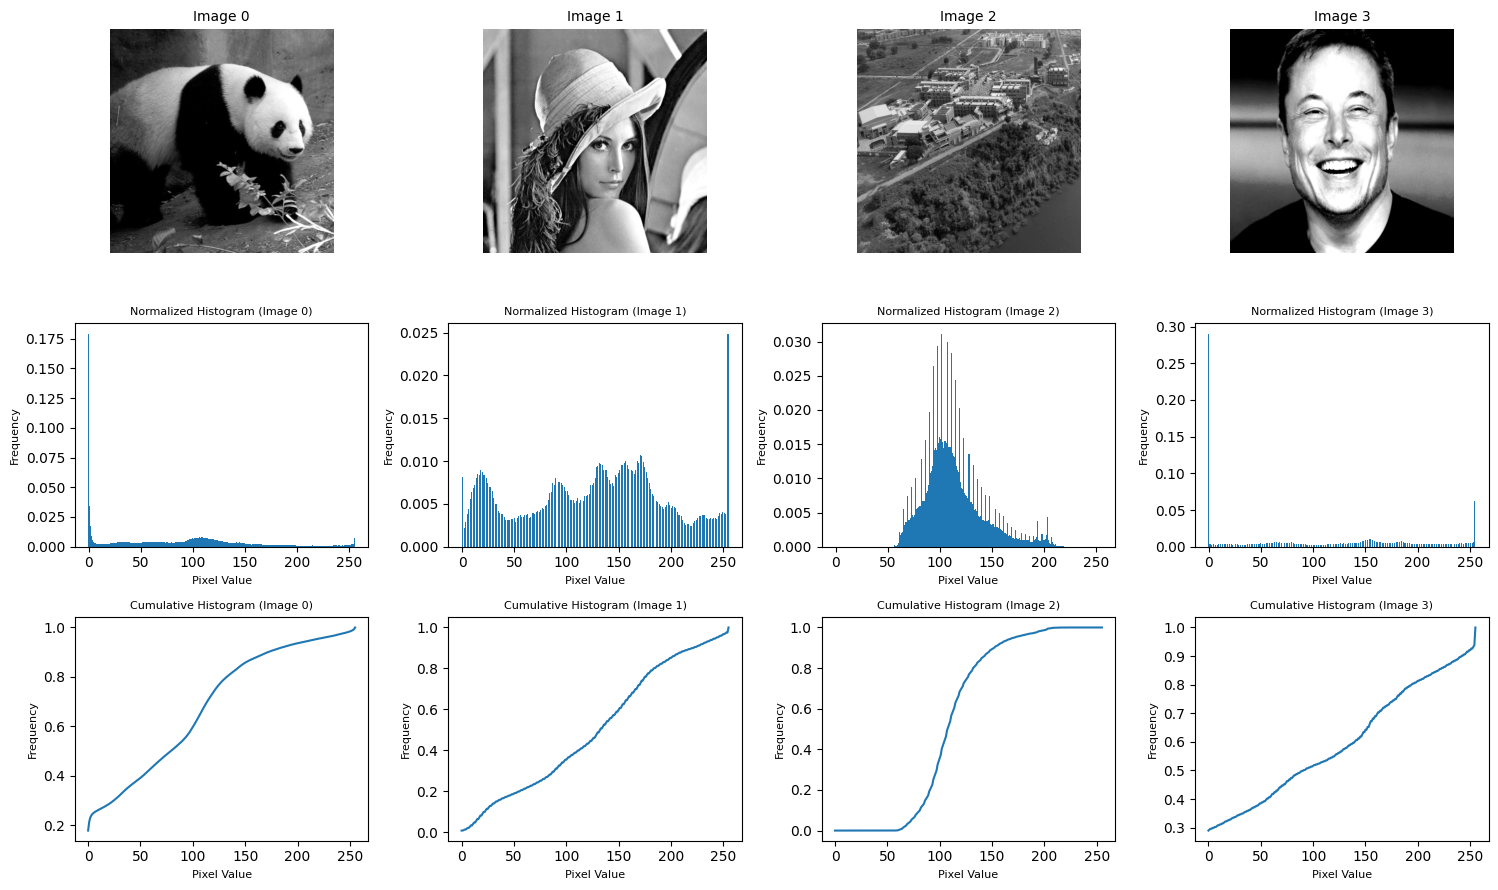

In [4]:
# this function is responsible for displaying the images and their histograms
def visualize_histograms(image_set, figsize=(15, 9), image_titles=None):
    plt.figure(figsize=figsize) # set the figure size

    for i, image in enumerate(image_set): # iterate over all the images
        histogram = calculate_histogram(image) # calculate the histogram of the image
        normalized_histogram = calculate_normalized_histogram(image) # calculate the normalized histogram of the image
        cumulative_histogram = calculate_cumulative_histogram(histogram) # calculate the cumulative histogram of the image
        
        plt.subplot(3, len(image_set), i + 1) # display the image
        plt.imshow(image, cmap='gray')
        plt.title(image_titles[i], fontsize=10)
        plt.axis('off')

        plt.subplot(3, len(image_set), i + 1 + len(image_set)) # display the histogram
        plt.bar(range(256), normalized_histogram, width=1.0)
        plt.title('Normalized Histogram ('+image_titles[i]+')', fontsize=8)
        plt.xlabel('Pixel Value', fontsize=8)
        plt.ylabel('Frequency', fontsize=8)

        plt.subplot(3, len(image_set), i + 1 + 2 * len(image_set)) # display the cumulative histogram
        plt.plot(cumulative_histogram)
        plt.title('Cumulative Histogram ('+image_titles[i]+')', fontsize=8)
        plt.xlabel('Pixel Value', fontsize=8)
        plt.ylabel('Frequency', fontsize=8)

    plt.tight_layout()
    plt.show()

# displaying the images and their histograms
visualize_histograms(image_set, image_titles=['Image 0', 'Image 1', 'Image 2', 'Image 3'])

### Implementing the algorithm

In [5]:
# this function is responsible for matching the histogram of an image to the histogram of a reference image
def match_histograms(image, reference_image):
    mapping = get_mapping(image, reference_image) # get the mapping
    matched_image = np.zeros(image.shape, dtype=np.uint8) # initialize the matched image
    for i in range(image.shape[0]): # match the image
        for j in range(image.shape[1]):
            matched_image[i, j] = mapping[image[i, j]]
    return matched_image # return the matched image

# this function is responsible for matching the histogram of an image to the histogram of a reference image
def get_mapping(image, reference_image, gray_levels=256):
    histogram = calculate_histogram(image) # calculate the histogram of the image
    cumulative_histogram = calculate_cumulative_histogram(histogram) # calculate the cumulative histogram of the image
    reference_histogram = calculate_histogram(reference_image) # calculate the histogram of the reference image
    reference_cumulative_histogram = calculate_cumulative_histogram(reference_histogram) # calculate the cumulative histogram of the reference image

    mapping = np.zeros(gray_levels) # initialize the mapping
    for pixel_value in range(gray_levels):
        old_value = cumulative_histogram[pixel_value] # get the cumulative histogram of the image
        temp = reference_cumulative_histogram - old_value # get the difference between the cumulative histogram of the reference image and the cumulative histogram of the image
        new_value = np.argmin(np.abs(temp)) # get the index of the minimum value in the difference
        mapping[pixel_value] = new_value # map the pixel value to the new value
    return mapping # return the mapping

In [6]:
# performing histogram matching and displaying the images and their histograms
def histogram_matching_and_visualization(image, reference_image, visualize=True): 
    matched_image = match_histograms(image, reference_image) # match the histogram of the image to the histogram of the reference image
    image_set = [image, reference_image, matched_image] 
    image_titles = ['Source Image', 'Target Image', 'Matched Image']
    if visualize:
        visualize_histograms(image_set, image_titles=image_titles) # display the images and their histograms   
    return matched_image # return the matched image  

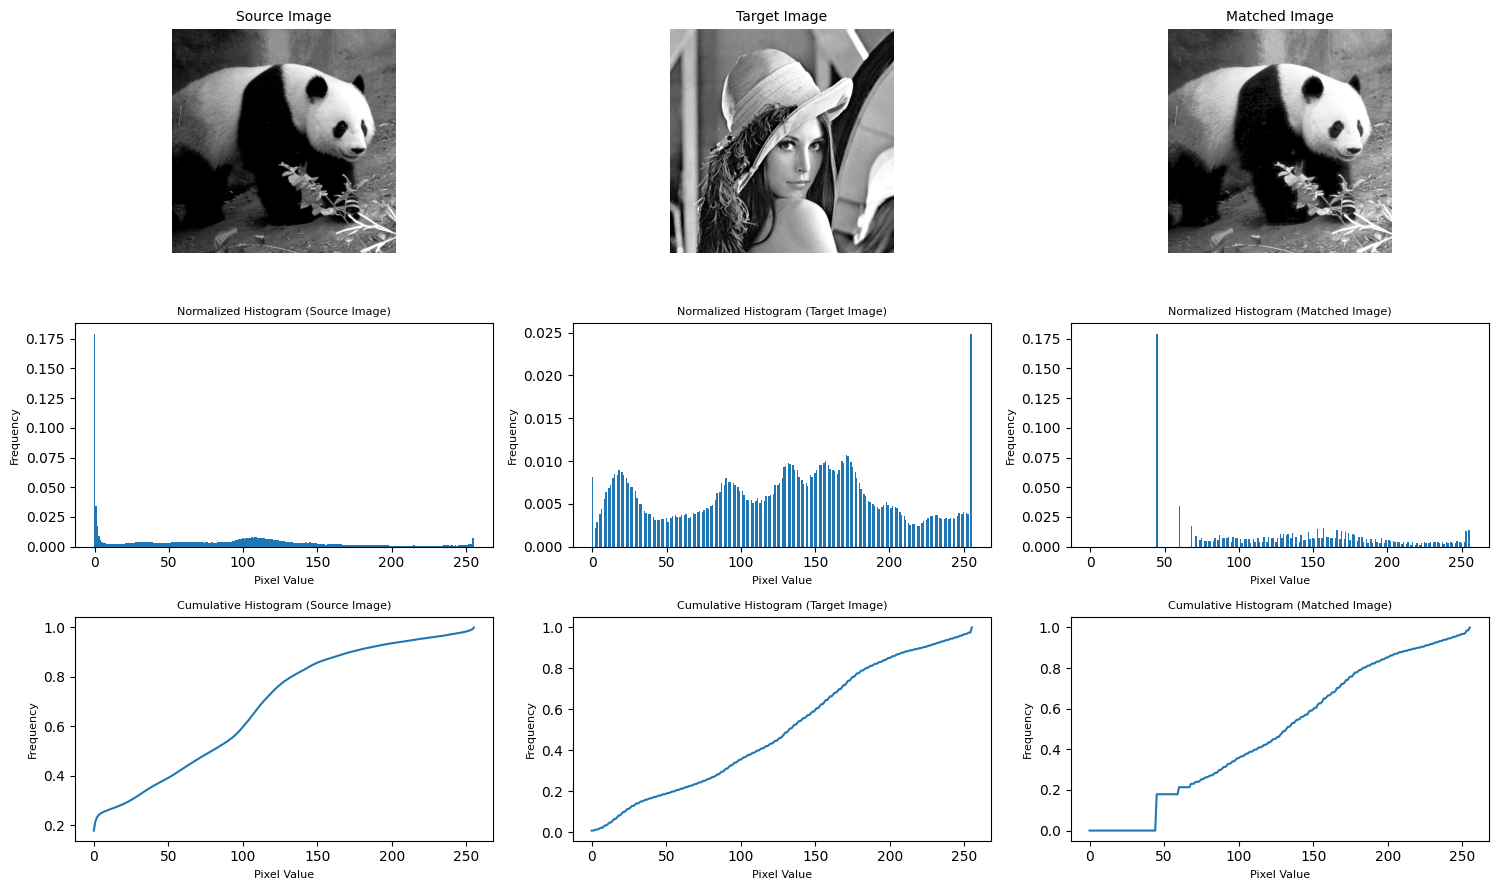

In [7]:
matching = histogram_matching_and_visualization(image_set[0], image_set[1])  

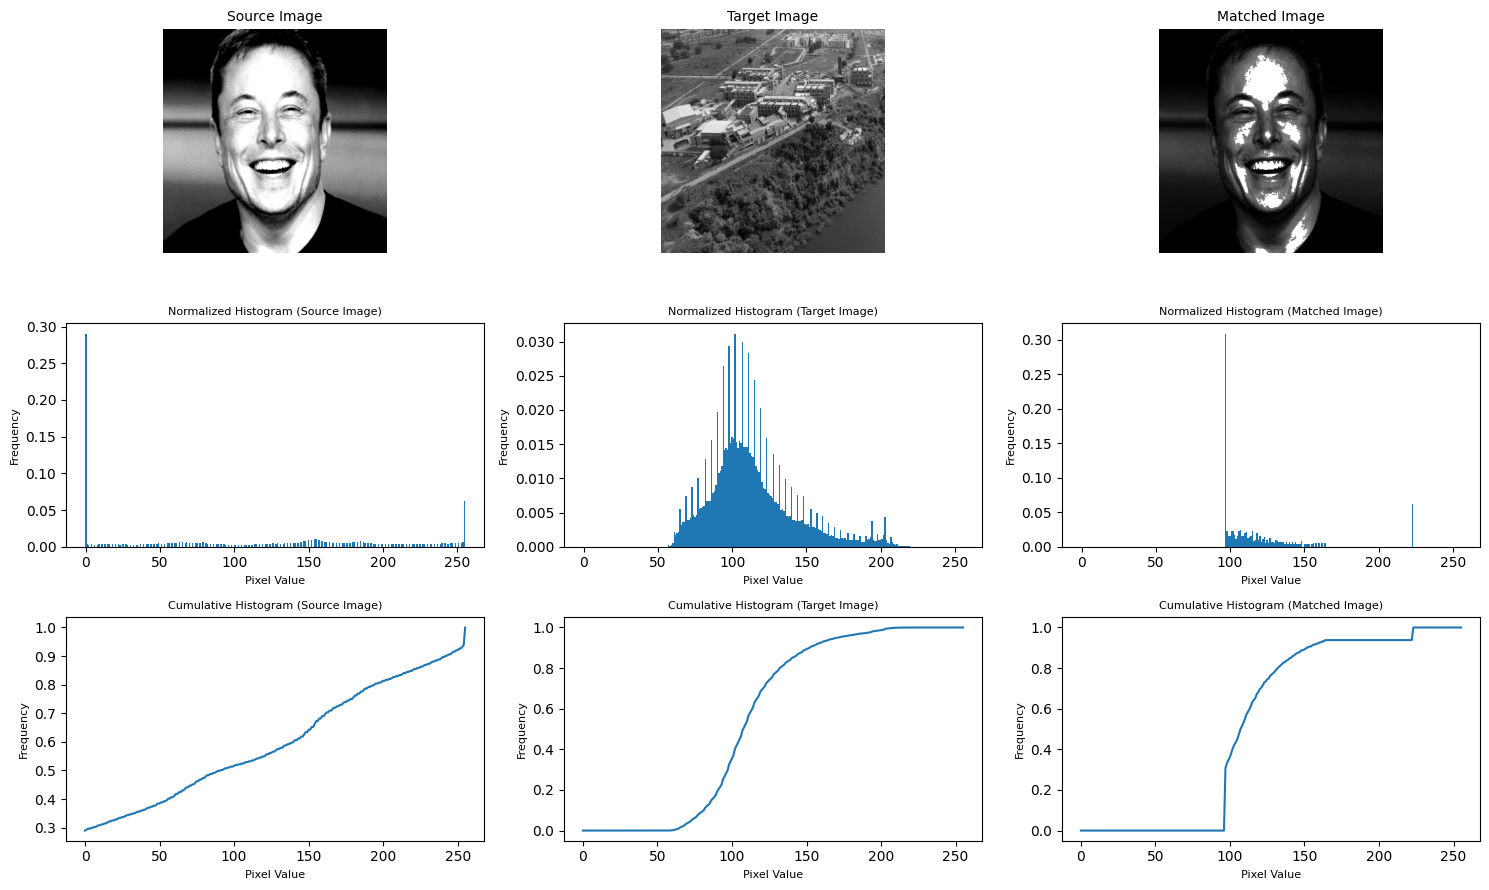

In [8]:
matching = histogram_matching_and_visualization(image_set[3], image_set[2])

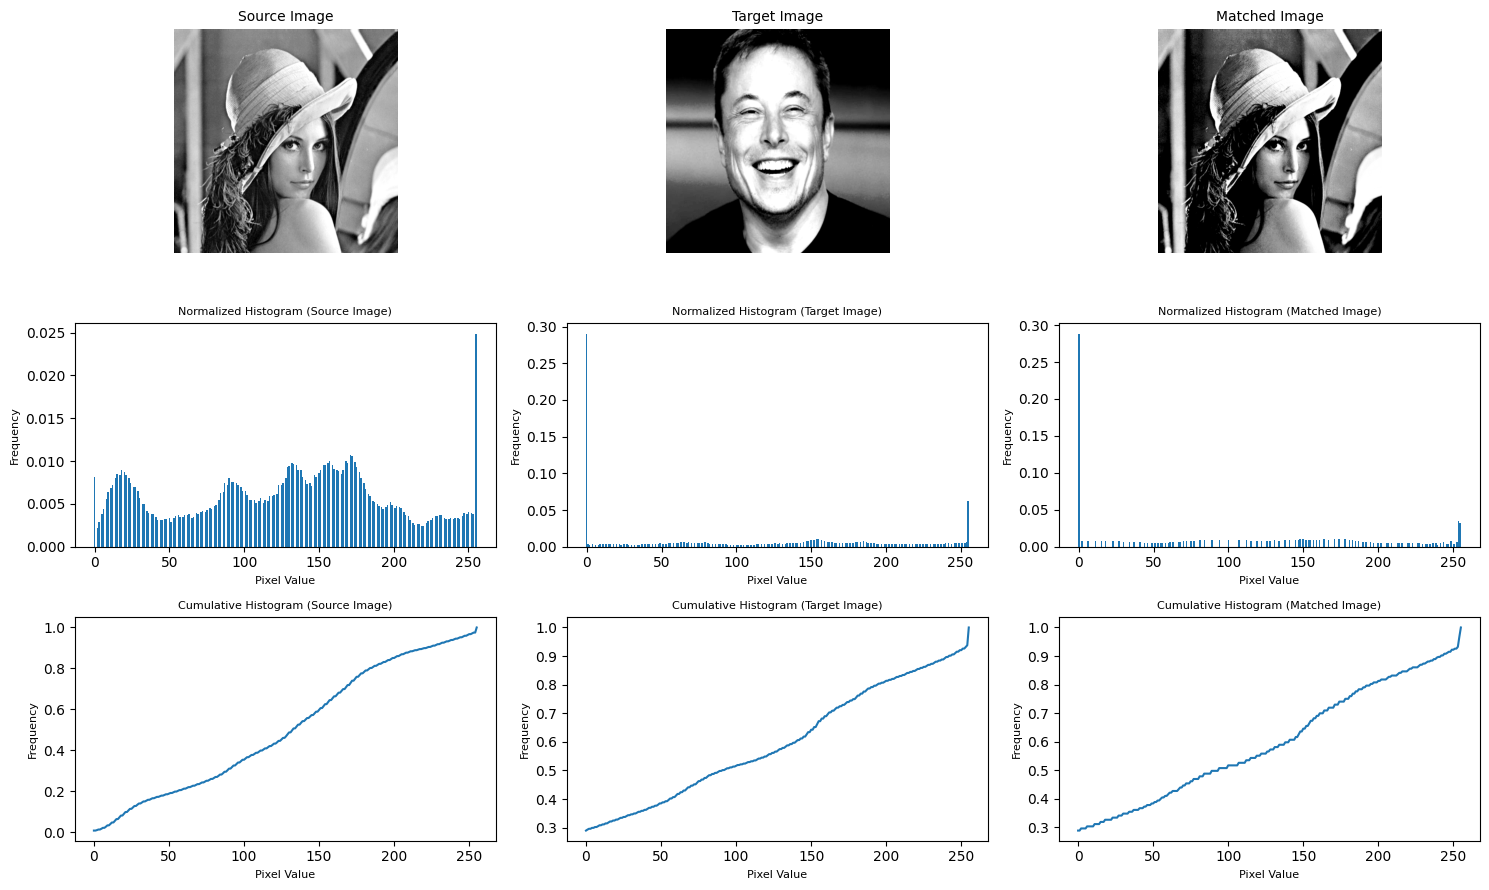

In [9]:
matching = histogram_matching_and_visualization(image_set[1], image_set[3])   

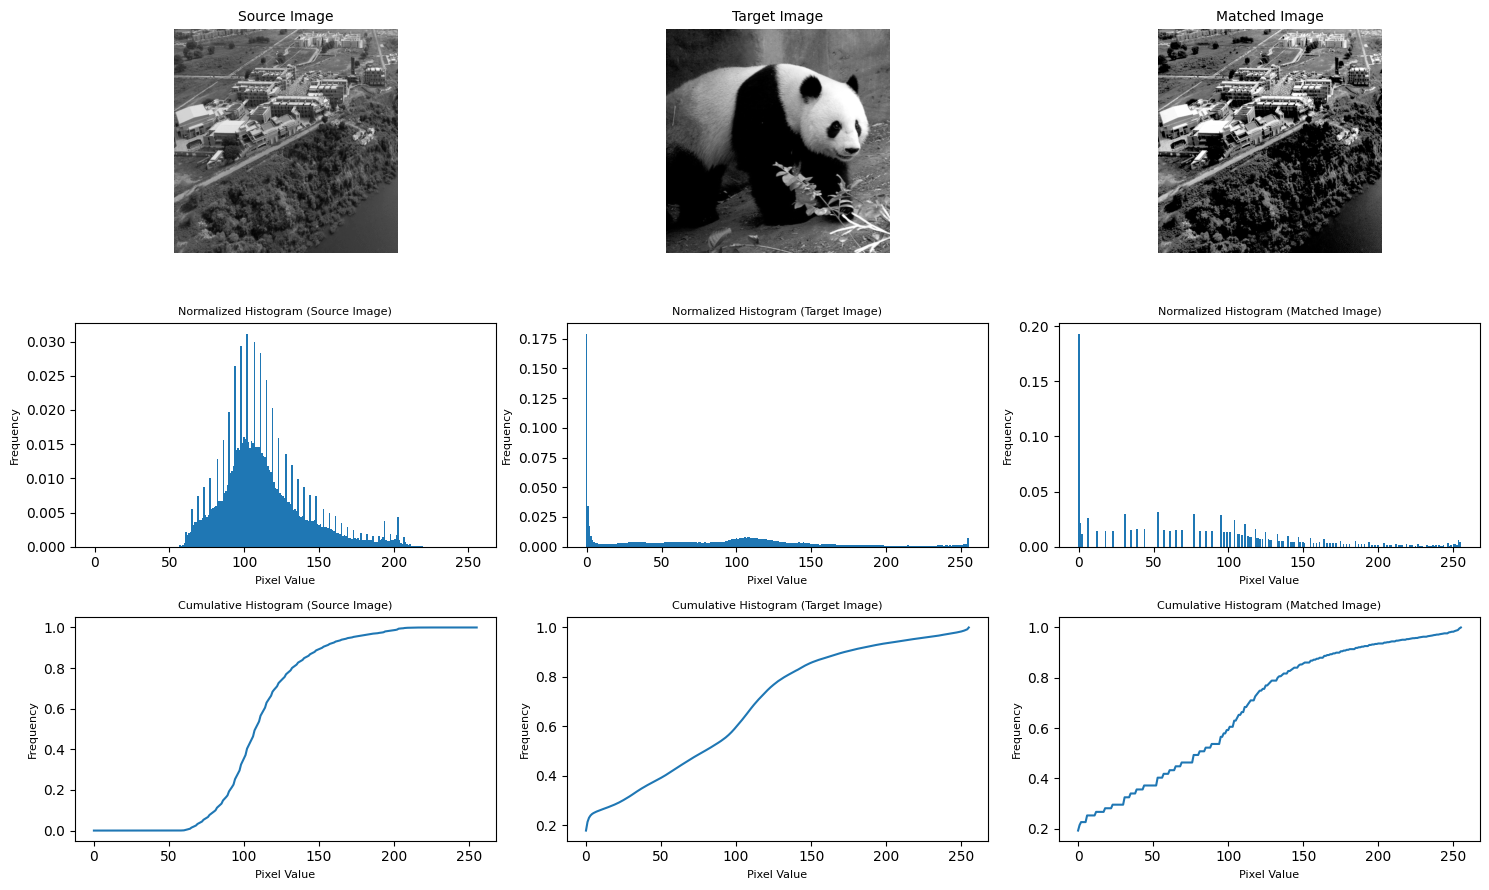

In [10]:
matching = histogram_matching_and_visualization(image_set[2], image_set[0])

### Analysis of the obtained resutls

In [11]:
import numpy as np
from scipy.stats import entropy
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

def calculate_image_statistics(original_image, target_image, matched_image):
    # Calculate Mean and Standard Deviation
    mean_original = np.mean(original_image)
    std_original = np.std(original_image)

    mean_target = np.mean(target_image)
    std_target = np.std(target_image)

    mean_matched = np.mean(matched_image)
    std_matched = np.std(matched_image)

    # Calculate SSIM
    ssim_score = ssim(original_image, matched_image)

    # Create a dictionary to store the statistics
    statistics = {
        "Original Mean": mean_original,
        "Original Standard Deviation": std_original,
        "Target Mean": mean_target,
        "Target Standard Deviation": std_target,
        "Matched Mean": mean_matched,
        "Matched Standard Deviation": std_matched,
        "SSIM Score (Source vs Matched)": ssim_score,
    }

    return statistics

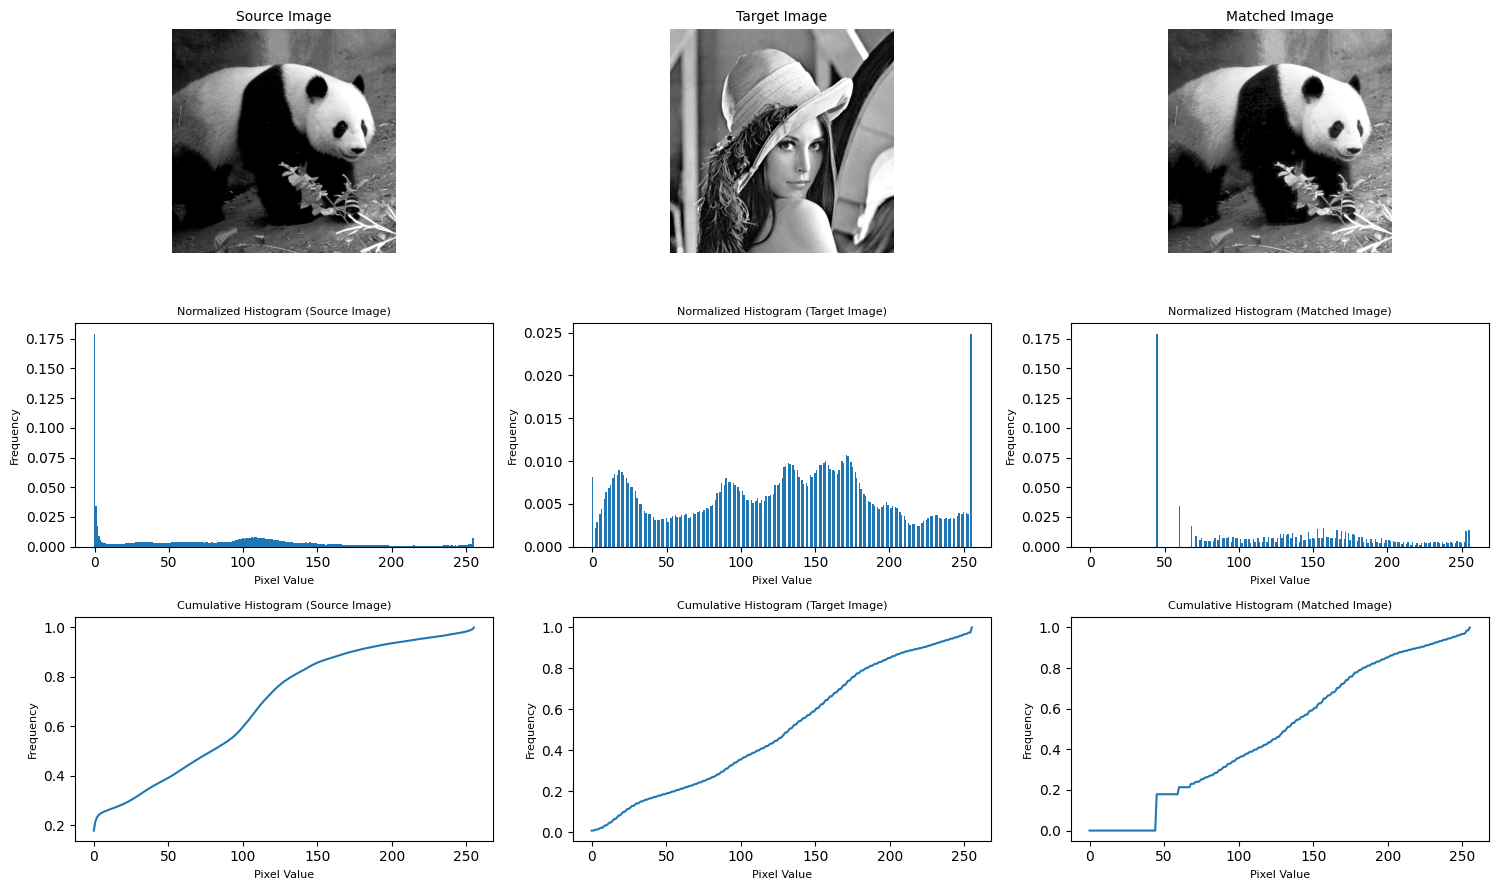

Original Mean: 80.04150772094727
Original Standard Deviation: 68.48801554947227
Target Mean: 126.48823547363281
Target Standard Deviation: 69.12917387622817
Matched Mean: 130.7914924621582
Matched Standard Deviation: 62.277325624710976
SSIM Score (Source vs Matched): 0.6362629163593398


In [12]:
matching = histogram_matching_and_visualization(image_set[0], image_set[1], visualize=True)
statistics = calculate_image_statistics(image_set[0], image_set[1], matching)
for key, value in statistics.items():
    print(f"{key}: {value}")

**Mean and Standard Deviation**

The original image has a mean of approximately 80.04 and a standard deviation of approximately 68.49.
The target image has a mean of approximately 126.49 and a standard deviation of approximately 69.13.
After the histogram matching process, the matched image has a mean of approximately 130.79 and a standard deviation of approximately 62.27.
Interpretation: The means have shifted towards each other after histogram matching, but the standard deviations have not changed significantly.

**SSIM Score**

The Structural Similarity Index (SSIM) score between the original and matched images is approximately 0.636.
Interpretation: An SSIM score of 1 indicates a perfect match. A score of 0.636 suggests that the matched image is reasonably similar to the original but not a perfect match.

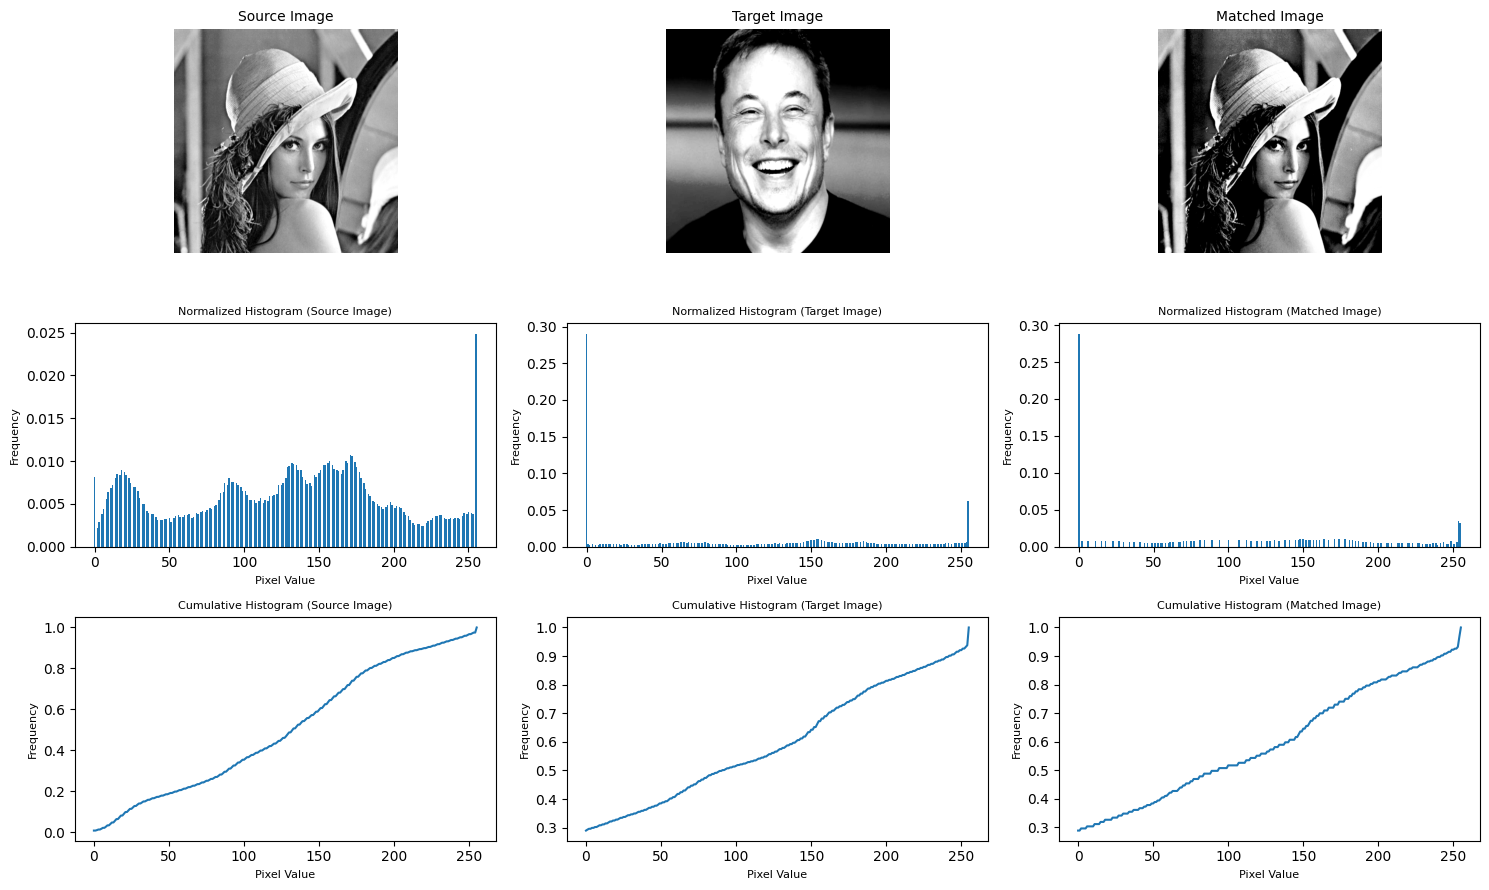

Original Mean: 126.48823547363281
Original Standard Deviation: 69.12917387622817
Target Mean: 102.53508758544922
Target Standard Deviation: 90.99119020648051
Matched Mean: 102.81129837036133
Matched Standard Deviation: 90.91224212665476
SSIM Score (Source vs Matched): 0.6144812508253021


In [13]:
matching = histogram_matching_and_visualization(image_set[1], image_set[3], visualize=True)
statistics = calculate_image_statistics(image_set[1], image_set[3], matching)
for key, value in statistics.items():
    print(f"{key}: {value}")

**Mean and Standard Deviation**

The original image has a mean of approximately 126.49 and a standard deviation of approximately 69.13.
The target image has a mean of approximately 102.54 and a standard deviation of approximately 90.99.
After the histogram matching process, the matched image has a mean of approximately 102.81 and a standard deviation of approximately 90.91.
Interpretation: Both the means and standard deviations have shifted towards the target image each other after histogram matching.

**SSIM Score**

The Structural Similarity Index (SSIM) score between the original and matched images is approximately 0.615.
Interpretation: The matched image is reasonably similar to the original, but it may not be a perfect match.

### References

- [Histogram matching Wikipedia](https://en.wikipedia.org/wiki/Histogram_matching)
- [Structural similarity index measure Wikipedia](https://en.wikipedia.org/wiki/Structural_similarity)
- [Histogram Matching, Google Earth Engine](https://developers.google.com/earth-engine/tutorials/community/histogram-matching)
- [Scikit-Image Histogram Matching](https://github.com/scikit-image/scikit-image/blob/main/skimage/exposure/histogram_matching.py)